In [1]:
import sys
import os

if sys.version_info[0] < 3:
  print('[ERROR] You need to run this with Python 3.')
  raise AssertionError

In [2]:
import numpy as np

import functools
import itertools
import toolz

from emtf_algos import *
from emtf_logger import get_logger
from emtf_colormap import get_colormap

In [3]:
# Set random seed
np.random.seed(2027)

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers as k_layers
from tensorflow.keras import backend as k_backend
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set random seed
tf.random.set_seed(2027)

#import numba
#from numba import njit, vectorize
import dask
import dask.array as da

logger = get_logger()
logger.info('Using cmssw      : {0}'.format(os.environ['CMSSW_VERSION'] if 'CMSSW_VERSION' in os.environ else 'n/a'))
logger.info('Using python     : {0}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {0}'.format(np.__version__))
logger.info('Using tensorflow : {0}'.format(tf.__version__))
logger.info('Using keras      : {0}'.format(keras.__version__))
logger.info('.. list devices  : {0}'.format(tf.config.list_physical_devices()))
logger.info('Using matplotlib : {0}'.format(mpl.__version__))
#logger.info('Using numba      : {0}'.format(numba.__version__))
logger.info('Using dask       : {0}'.format(dask.__version__))

assert k_backend.backend() == 'tensorflow'
assert k_backend.image_data_format() == 'channels_last'

%matplotlib inline

[INFO    ] Using cmssw      : CMSSW_10_6_3
[INFO    ] Using python     : 3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) [GCC 7.3.0]
[INFO    ] Using numpy      : 1.19.2
[INFO    ] Using tensorflow : 2.4.0
[INFO    ] Using keras      : 2.4.0
[INFO    ] .. list devices  : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[INFO    ] Using matplotlib : 3.3.2
[INFO    ] Using dask       : 2020.12.0


In [4]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
zone = 0
#zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(0,-1,-2)
timezone = 0

# masked array filling value
ma_fill_value = 999999

#maxevents = 10
maxevents = -1

workers = 1
#workers = 8

# Input files
features_fname = 'features_merge.h5'


# Scheduler
dask.config.set(scheduler='threads', num_workers=workers)

# Styling
plt.style.use('tdrstyle.mplstyle')
cm = get_colormap()

logger.info('Processing zone {0} timezone {1}'.format(zone, timezone))
logger.info('.. maxevents        : {0}'.format(maxevents))
logger.info('.. workers          : {0}'.format(workers))

[INFO    ] Processing zone 0 timezone 0
[INFO    ] .. maxevents        : -1
[INFO    ] .. workers          : 1


In [5]:
# Import ML stuff

# tensorflow-probability
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfp_layers = tfp.layers

# tensorflow-addons
import tensorflow_addons as tfa

# custom layers
from k_preprocessing_normalization import Normalization as MyNormalization
from k_layers_dense import Dense as MyDense
from k_losses_huber import Huber as MyHuber

### Load data

In [6]:
import h5py
file_handles = []

def load_features():
  fname = features_fname
  logger.info('Loading from {0}'.format(fname))
  loaded = h5py.File(fname, 'r')
  file_handles.append(loaded)
  features = da.from_array(loaded['features'])
  truths = da.from_array(loaded['truths'])

  features = np.array(features)  # lazy no more
  truths = np.array(truths)  # lazy no more
  logger.info('features: {0} truths: {1}'.format(features.shape, truths.shape))
  logger.info('features: {0} truths: {1}'.format(features.dtype, truths.dtype))
  return features, truths

In [7]:
# Load features and truths
features, truths = load_features()

for file_handle in file_handles:  # close files
  file_handle.close()

[INFO    ] Loading from features_merge.h5
[INFO    ] features: (1590732, 40) truths: (1590732, 9)
[INFO    ] features: int32 truths: float32


In [8]:
def train_test_split(*arrays, test_size=0.4, shuffle=True):
  assert(len(arrays) >= 2)
  num_samples = arrays[0].shape[0]
  num_train_samples = int(np.ceil(num_samples * (1.0 - test_size)))
  num_test_samples = num_samples - num_train_samples
  index_array = np.arange(num_samples)
  if shuffle:
    np.random.shuffle(index_array)
  index_array_train, index_array_test = index_array[:num_train_samples], index_array[num_train_samples:]

  train_test_pairs = (
      (arr[index_array_train], arr[index_array_test])
      for arr in arrays
  )
  return tuple(itertools.chain.from_iterable(train_test_pairs))

In [9]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(features, truths)

# Convert x_train, x_test to floating-point
ismasked = lambda x: x == ma_fill_value
x_train_mask = ismasked(x_train)
x_test_mask = ismasked(x_test)
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# Modify parameter of interest
pt_regr_scale = 1.
pt_regr_sigma_scale = 0.01
pt_regr_sigma_bias = np.log(np.expm1(0.0015))
sample_weight = 500
y_train = y_train[:, 0:1]
y_test = y_test[:, 0:1]
y_train *= pt_regr_scale
y_test *= pt_regr_scale

logger.info('x_train: {0} y_train: {1} x_test: {2} y_test: {3}'.format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))
logger.info('x_train: {0} y_train: {1} x_test: {2} y_test: {3}'.format(x_train.dtype, y_train.dtype, x_test.dtype, y_test.dtype))

[INFO    ] x_train: (954440, 40) y_train: (954440, 1) x_test: (636292, 40) y_test: (636292, 1)
[INFO    ] x_train: float32 y_train: float32 x_test: float32 y_test: float32


### Create model

In [10]:
# Preprocessing layer
preprocessing_layer = MyNormalization(mask_value=ma_fill_value)
preprocessing_layer.adapt(x_train)
#print(preprocessing_layer.mean.numpy())
#print(preprocessing_layer.variance.numpy())

#y_preprocessing_layer = MyNormalization()
#y_preprocessing_layer.adapt(y_train)
#print(y_preprocessing_layer.mean.numpy())
#print(y_preprocessing_layer.variance.numpy())

# Get rid of mask
#x_train[x_train_mask] = 0
#x_test[x_test_mask] = 0

In [11]:
default_learning_rate = 0.001
learning_rate = 0.0025
gradient_clip_norm = 1.

def create_model(nodes1=30, nodes2=20, nodes3=10, nodes_in=40, nodes_out=1):
  inputs = keras.Input(shape=(nodes_in,), dtype='float32', name='inputs')

  # Preprocessing
  x = preprocessing_layer(inputs)

  # Sequential
  seq = keras.Sequential([
      # Hidden layer 1
      MyDense(nodes1, kernel_initializer='glorot_uniform', use_bias=False, activation=None, mask_value=ma_fill_value),
      k_layers.BatchNormalization(epsilon=1e-4, momentum=0.9),
      k_layers.Activation('tanh'),
      # Hidden layer 2
      k_layers.Dense(nodes2, kernel_initializer='glorot_uniform', use_bias=False, activation=None),
      k_layers.BatchNormalization(epsilon=1e-4, momentum=0.9),
      k_layers.Activation('tanh'),
      # Hidden layer 3
      k_layers.Dense(nodes3, kernel_initializer='glorot_uniform', use_bias=False, activation=None),
      k_layers.BatchNormalization(epsilon=1e-4, momentum=0.9),
      k_layers.Activation('tanh'),
      # Output layer
      k_layers.Dense(nodes_out + nodes_out, kernel_initializer='zeros', use_bias=True, activation=None),
      tfp_layers.DistributionLambda(
          lambda t: tfd.Normal(loc=t[..., :1],
              scale=tf.math.maximum(1e-5, tf.math.softplus(pt_regr_sigma_scale * (t[..., 1:] + pt_regr_sigma_bias)))),
          convert_to_tensor_fn=tfd.Distribution.sample,
          name='awesome_layer'),
  ], name='awesome_sequential')
  x = seq(x)

  outputs = x

  # Loss & optimizer
  adam = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=gradient_clip_norm)
  #readam = tfa.optimizers.RectifiedAdam(learning_rate=learning_rate, clipnorm=gradient_clip_norm)
  #nll_loss = lambda y, rv_y: -rv_y.log_prob(y)
  #mse_loss = keras.losses.MeanSquaredError()
  huber_loss = MyHuber()
  weighted_huber_loss = lambda y_true, y_pred: huber_loss(y_true, y_pred, sample_weight=sample_weight)

  # Model
  model = keras.Model(inputs=inputs, outputs=outputs, name='awesome_model')
  model.compile(optimizer=adam, loss=weighted_huber_loss)

  # Summary
  model.summary()
  seq.summary()
  print('Learning rate: {0}'.format(learning_rate))
  return model

model = create_model()

Model: "awesome_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 40)]              0         
_________________________________________________________________
normalization (Normalization (None, 40)                120       
_________________________________________________________________
awesome_sequential (Sequenti multiple                  2262      
Total params: 2,382
Trainable params: 2,142
Non-trainable params: 240
_________________________________________________________________
Model: "awesome_sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                1200      
_________________________________________________________________
batch_normalization (BatchNo (None, 30)                120       
_____________________

### Train model

In [12]:
class ModelTrainer(object):
  def __init__(self, model, log_dir='keras_logs', prefix='', suffix='.log'):
    self.model = model
    self.log_dir = log_dir
    self.prefix = prefix
    self.suffix = suffix

  def fit(self, *args, **kwargs):
    from contextlib import redirect_stdout
    from datetime import datetime
    import os
    import tempfile
    if not os.path.exists(self.log_dir):
      os.makedirs(self.log_dir)
    fd, name = tempfile.mkstemp(prefix=self.prefix, suffix=self.suffix, dir=self.log_dir, text=True)

    start_time = datetime.now()
    logger.info('Begin training ...')

    with os.fdopen(fd, 'w') as f:
      with redirect_stdout(f):
        ret = self.model.fit(*args, **kwargs)

    logger.info('Done training. Time elapsed: {0}'.format(str(datetime.now() - start_time)))
    return ret

class HistoryPlotter(object):
  def __init__(self, history, metric=None):
    self.history = history
    if metric is None:
      metric = 'loss'
    self.metric = metric

  def plot(self):
    with plt.rc_context({'figure.figsize': (3, 3)}):
      train_value = self.history.history[self.metric]
      val_value = self.history.history['val_' + self.metric]

      plt.plot(self.history.epoch, train_value, color='C0', label='Train')
      plt.plot(self.history.epoch, val_value, '--', color='C0', label='Val')
      plt.xlabel('Epochs')
      plt.ylabel(self.metric.replace('_', ' ').title())
      plt.legend(loc='upper right')
      #plt.ylim(0,1)
      plt.grid(True)

    _info = (len(self.history.epoch), self.metric, train_value[-1], 'val_' + self.metric, val_value[-1])
    logger.info('Epoch {0:d}/{0:d} - {1}: {2:.4f} - {3}: {4:.4f}'.format(*_info))
    return

[INFO    ] Begin training ...
[INFO    ] Done training. Time elapsed: 0:02:51.194207
[INFO    ] Epoch 100/100 - loss: 0.4313 - val_loss: 0.4119


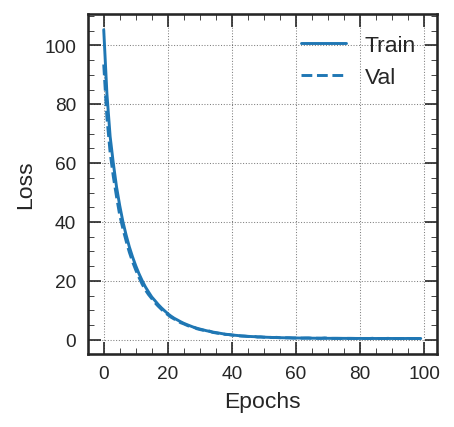

In [13]:
epochs = 100
batch_size = 2048
callbacks = None

history = ModelTrainer(model).fit(x_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=1)

HistoryPlotter(history).plot()

### Evaluate model

In [14]:
def gaus(x,a,mu,sig):
  return a*np.exp(-0.5*np.square((x-mu)/sig))

def fit_gaus(hist, edges, mu=0., sig=1.):
  from scipy.optimize import curve_fit
  hist = hist.astype(np.float64)
  edges = edges.astype(np.float64)
  xdata = (edges[1:] + edges[:-1])/2
  ydata = hist
  popt, pcov = curve_fit(gaus, xdata, ydata, p0=[np.max(hist), mu, sig])
  if not np.isfinite(pcov).all():
    raise Exception('Fit has failed to converge.')
  return popt

def mean_squared_error(y_true, y_pred):
  # K.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
  return keras.losses.mean_squared_error(y_true, y_pred).numpy()

def mean_absolute_error(y_true, y_pred):
  # K.mean(math_ops.abs(y_pred - y_true), axis=-1)
  return keras.losses.mean_absolute_error(y_true, y_pred).numpy()

def median_absolute_deviation(y_true, y_pred):
  scale = 0.6744897501960817  # special.ndtri(0.75)
  return np.median(np.abs(y_pred - y_true), axis=-1) / scale

In [15]:
# Make predictions
y_test_true = y_test.copy()
#y_test_pred = model.predict(x_test, batch_size=8192)

rv_y = model(x_test)
y_test_pred = rv_y.loc.numpy()
y_test_pred_scale = rv_y.scale.numpy()
y_test_pred_scale_logit = (np.log(np.expm1(y_test_pred_scale)) - pt_regr_sigma_bias) / pt_regr_sigma_scale

y_test_true /= pt_regr_scale
y_test_pred /= pt_regr_scale

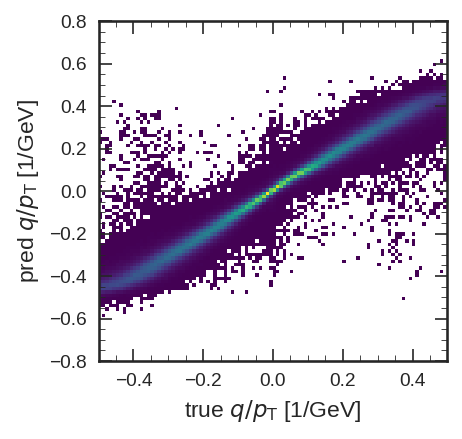

In [16]:
# Plot result
fig, ax = plt.subplots(figsize=(3,3))
xx = y_test_true
yy = y_test_pred
ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.8,0.8)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred $q/p_{\mathrm{T}}$ [1/GeV]')
plt.show()

[INFO    ] (entries, mu, sig, mse, mae, mad): 636292, -1.3628e-03, 0.0365, 0.0016, 0.0263, 0.0390
[INFO    ] gaus fit (a, mu, sig): 45339.1, 4.9426e-04, 0.0259
[INFO    ] (entries, mu, sig, mse, mae, mad): 103258, 6.3306e-03, 0.0187, 0.0007, 0.0159, 0.0162
[INFO    ] gaus fit (a, mu, sig): 4785.0, 6.2273e-03, 0.0132


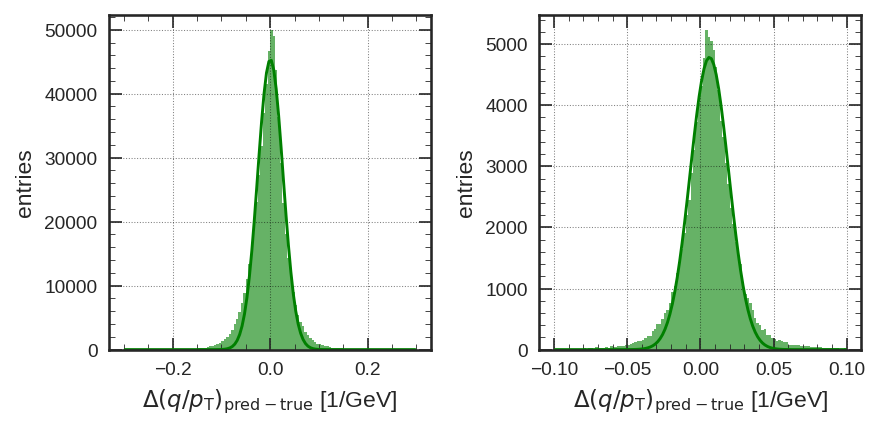

In [17]:
# Plot Delta(q/pt)
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = y_test_true
yb = y_test_pred
yy = yb - ya
yy_core = yy[np.abs(yy)<0.3]

ax = axs[0]
hist, edges, _ = ax.hist(yy, bins=120, range=(-0.3,0.3), histtype='stepfilled', facecolor='g', alpha=0.6)
mu, sig, mse, mae, mad = np.mean(yy_core), np.std(yy_core), mean_squared_error(ya, yb).mean(), mean_absolute_error(ya, yb).mean(), median_absolute_deviation(ya, yb).mean()
popt = fit_gaus(hist, edges, mu=mu, sig=sig)
logger.info('(entries, mu, sig, mse, mae, mad): {0:d}, {1:.4e}, {2:.4f}, {3:.4f}, {4:.4f}, {5:.4f}'.format(len(yy), mu, sig, mse, mae, mad))
logger.info('gaus fit (a, mu, sig): {0:.1f}, {1:.4e}, {2:.4f}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
ax.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')

# Repeat with pt > 14 GeV
sel = (np.abs(1.0/y_test_true) > 14)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]
yy_core = yy[np.abs(yy)<0.3/3]

ax = axs[1]
hist, edges, _ = ax.hist(yy, bins=120, range=(-0.3/3,0.3/3), histtype='stepfilled', facecolor='g', alpha=0.6)
mu, sig, mse, mae, mad = np.mean(yy_core), np.std(yy_core), mean_squared_error(ya, yb).mean(), mean_absolute_error(ya, yb).mean(), median_absolute_deviation(ya, yb).mean()
popt = fit_gaus(hist, edges, mu=mu, sig=sig)
logger.info('(entries, mu, sig, mse, mae, mad): {0:d}, {1:.4e}, {2:.4f}, {3:.4f}, {4:.4f}, {5:.4f}'.format(len(yy), mu, sig, mse, mae, mad))
logger.info('gaus fit (a, mu, sig): {0:.1f}, {1:.4e}, {2:.4f}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
ax.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')

plt.show()

[INFO    ] (entries, mu, sig, mse, mae, mad): 636292, -1.2738e-03, 0.2384, 2002.2070, 0.4567, 0.6772
[INFO    ] gaus fit (a, mu, sig): 41783.1, -1.0225e-02, 0.1345
[INFO    ] (entries, mu, sig, mse, mae, mad): 103258, -9.9422e-02, 0.4373, 1222.2019, 1.5883, 0.4390
[INFO    ] gaus fit (a, mu, sig): 2828.1, -1.6897e-01, 0.3032


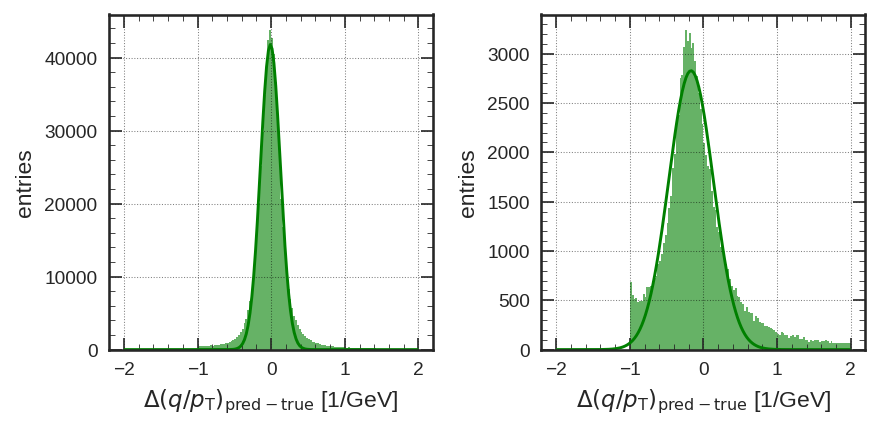

In [18]:
# Plot Delta(q/pt) / pt
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = np.abs(y_test_true/y_test_true)
yb = np.abs(y_test_true/y_test_pred)
yy = yb - ya
yy_core = yy[np.abs(yy)<1.5]

ax = axs[0]
hist, edges, _ = ax.hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
mu, sig, mse, mae, mad = np.mean(yy_core), np.std(yy_core), mean_squared_error(ya, yb).mean(), mean_absolute_error(ya, yb).mean(), median_absolute_deviation(ya, yb).mean()
popt = fit_gaus(hist, edges, mu=mu, sig=sig)
logger.info('(entries, mu, sig, mse, mae, mad): {0:d}, {1:.4e}, {2:.4f}, {3:.4f}, {4:.4f}, {5:.4f}'.format(len(yy), mu, sig, mse, mae, mad))
logger.info('gaus fit (a, mu, sig): {0:.1f}, {1:.4e}, {2:.4f}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
ax.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')

# Repeat with pT > 14 GeV
sel = (np.abs(1.0/y_test_true) > 14)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]
yy_core = yy[np.abs(yy)<1.5]

ax = axs[1]
hist, edges, _ = ax.hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
mu, sig, mse, mae, mad = np.mean(yy_core), np.std(yy_core), mean_squared_error(ya, yb).mean(), mean_absolute_error(ya, yb).mean(), median_absolute_deviation(ya, yb).mean()
popt = fit_gaus(hist, edges, mu=mu, sig=sig)
logger.info('(entries, mu, sig, mse, mae, mad): {0:d}, {1:.4e}, {2:.4f}, {3:.4f}, {4:.4f}, {5:.4f}'.format(len(yy), mu, sig, mse, mae, mad))
logger.info('gaus fit (a, mu, sig): {0:.1f}, {1:.4e}, {2:.4f}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
ax.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')

plt.show()

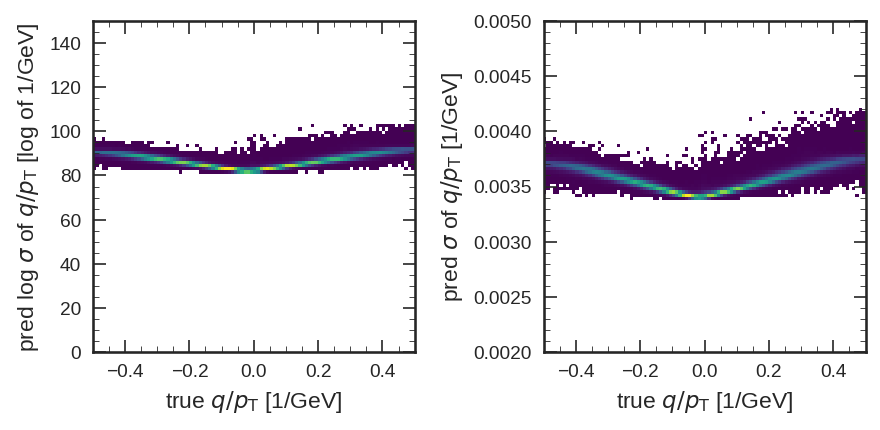

In [19]:
# Plot 'sigma'
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

xx = y_test_true
yy = y_test_pred_scale_logit
ax = axs[0]
ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(0, 150)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred log $\sigma$ of $q/p_{\mathrm{T}}$ [log of 1/GeV]')

xx = y_test_true
yy = y_test_pred_scale
ax = axs[1]
ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(0.002, 0.005)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred $\sigma$ of $q/p_{\mathrm{T}}$ [1/GeV]')

plt.show()

86.71981 2.8685164


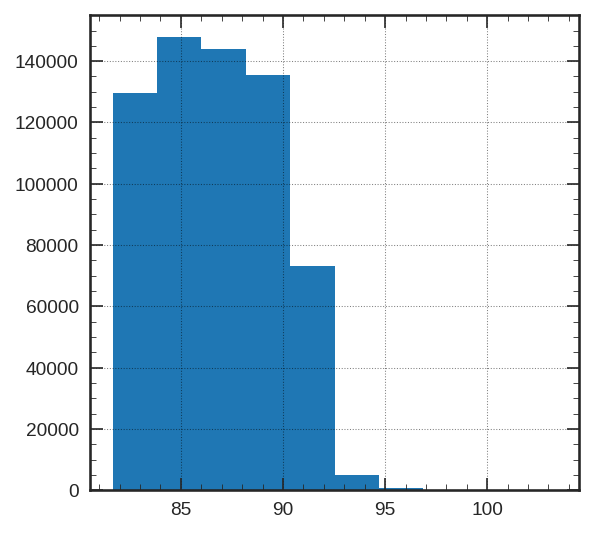

In [20]:
#FIXME
print(y_test_pred_scale_logit.mean(), y_test_pred_scale_logit.std())
plt.hist(y_test_pred_scale_logit)
plt.show()

0.0035681224


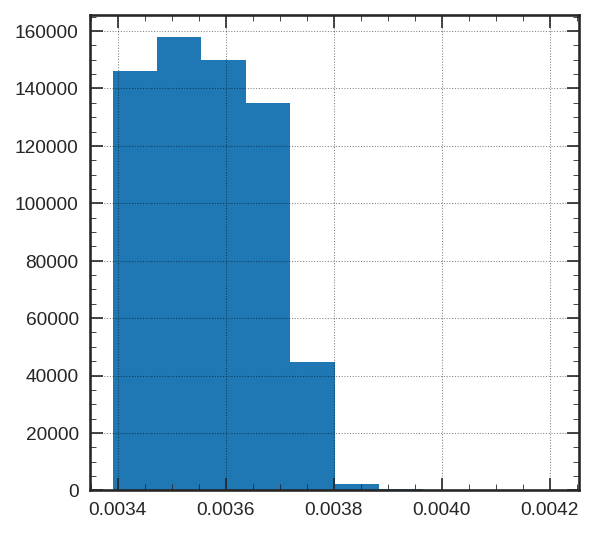

In [21]:
#FIXME
print(y_test_pred_scale.mean())
plt.hist(y_test_pred_scale)
plt.show()

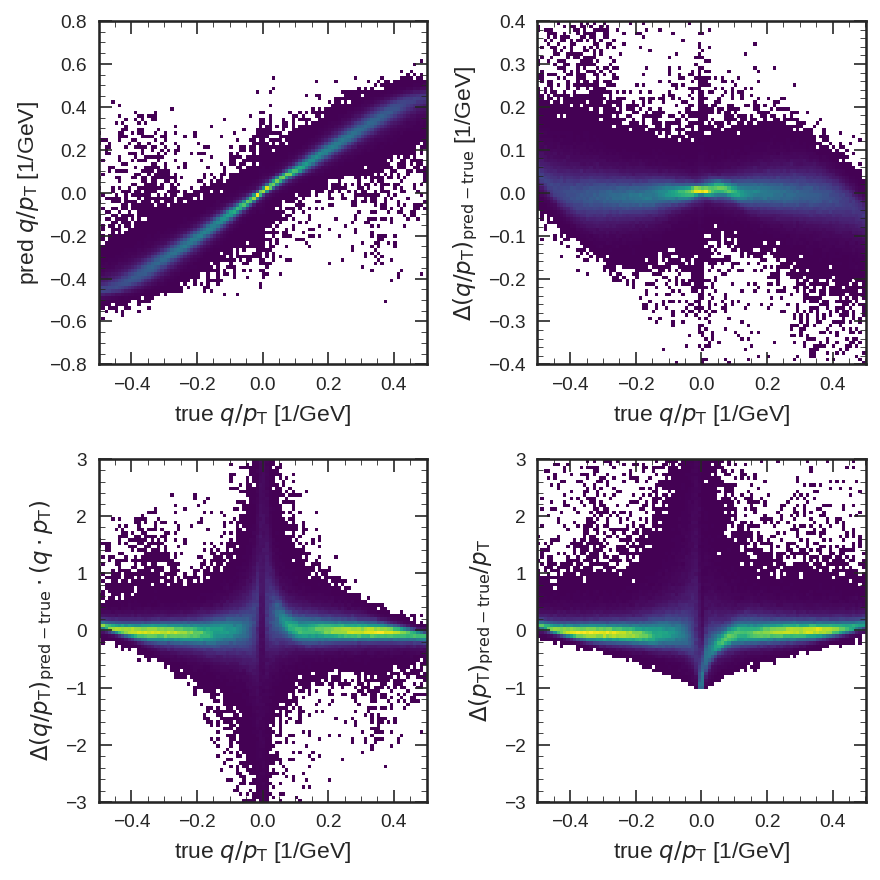

In [22]:
# Plot correlations
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

xx = y_test_true
yy = y_test_pred
ax = axs[0,0]
ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.8,0.8)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred $q/p_{\mathrm{T}}$ [1/GeV]')

yy = y_test_pred - y_test_true
ax = axs[0,1]
ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.4,0.4)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')

yy = (y_test_pred - y_test_true)/np.abs(y_test_true)
ax = axs[1,0]
ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}} \cdot (q \cdot p_{\mathrm{T}})$')

yy = np.abs(y_test_true/y_test_pred) - 1
ax = axs[1,1]
ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{pred-true}} / p_{\mathrm{T}}$')

plt.show()

In [23]:
# Make better resolution plot
# resolution defined as Delta(pt) over pt (no charge), binned in 1/pt (also no charge)
xx = np.abs(y_test_true)
yy = np.abs(y_test_true/y_test_pred) - 1
xx = np.squeeze(xx)
yy = np.squeeze(yy)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
zzz = np.zeros(nbinsx, dtype=np.float32)
ttt = np.zeros(nbinsx, dtype=np.float32)
uuu = np.zeros(nbinsx, dtype=np.float32)

for i in range(nbinsx):
  xx_i = xx[inds==i]
  if len(xx_i) < 100:  # not enough stats
    continue

  pt = np.mean(xx_i)
  pt = 1.0/pt

  yy_i = yy[inds==i]
  yy_i = yy_i[(-1.0 <= yy_i) & (yy_i <= 1.5)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1.0)
  assert(np.abs(sig) < 2.0)

  hist, edges = np.histogram(yy_i, bins=160, range=(-2,2))
  xdata = (edges[1:] + edges[:-1])/2
  try:
    popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  except:
    popt = np.array([np.nan, np.nan, np.nan])
  #print(i, len(xx_i), mu, sig, pt, popt)

  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = hist - ydata
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  hightail = zdata.sum()/len(xx_i)
  #print(i, len(xx_i), zdata.sum(), hightail)

  # Estimate coverage
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  coverage = -1*pct[0]/popt[2]

  if 14. < pt < 15.:
    ind_14GeV, xx_14GeV, yy_14GeV = i, xx_i, yy_i
  elif 20. < pt < 22.:
    ind_20GeV, xx_20GeV, yy_20GeV = i, xx_i, yy_i
  elif 25. < pt < 28.:
    ind_25GeV, xx_25GeV, yy_25GeV = i, xx_i, yy_i
  elif 28. < pt < 33.:
    ind_30GeV, xx_30GeV, yy_30GeV = i, xx_i, yy_i

  xxx[i] = pt
  yyy[i] = popt[2]
  zzz[i] = hightail
  ttt[i] = coverage
  uuu[i] = popt[1]

[INFO    ] gaus fit (a, mu, sig): 350.8, -1.0487e-01, 0.1845
[INFO    ] gaus fit (a, mu, sig): 272.2, -1.4709e-01, 0.2281


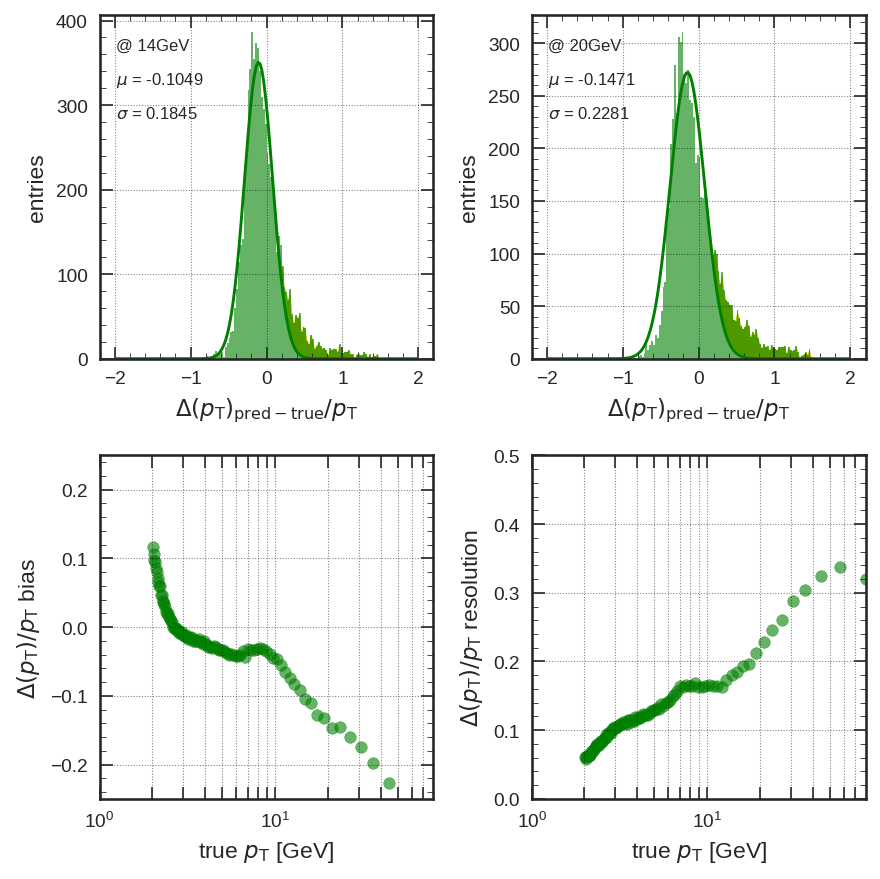

In [24]:
# Make better resolution plot
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

def doit():
  hist, edges, _ = ax.hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
  xdata = (edges[1:] + edges[:-1])/2
  try:
    popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  except:
    popt = np.array([np.nan, np.nan, np.nan])
  logger.info('gaus fit (a, mu, sig): {0:.1f}, {1:.4e}, {2:.4f}'.format(popt[0], popt[1], popt[2]))

  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = hist - ydata
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail

  ax.plot(xdata, ydata, color='g')
  ax.fill_between(xdata, ydata, ydata+zdata, facecolor='y')
  ax.text(0.05, 0.9, r'@ %iGeV' % pt, transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=ax.transAxes, fontsize=8)
  ax.set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{pred-true}} / p_{\mathrm{T}}$')
  ax.set_ylabel(r'entries')

ax = axs[0,0]
yy = yy_14GeV
pt = 14
doit()

ax = axs[0,1]
yy = yy_20GeV
pt = 20
doit()

ax = axs[1,0]
ax.scatter(xxx, uuu, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(-0.25,0.25)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}}) / p_{\mathrm{T}}$ bias')
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))

ax = axs[1,1]
ax.scatter(xxx, yyy, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.5)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}}) / p_{\mathrm{T}}$ resolution')
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))

plt.show()

[INFO    ] high tail prob: 0.1135, 0.1375, 0.1318
[INFO    ] coverage # of sigmas: 1.6121, 1.5959, 1.5909


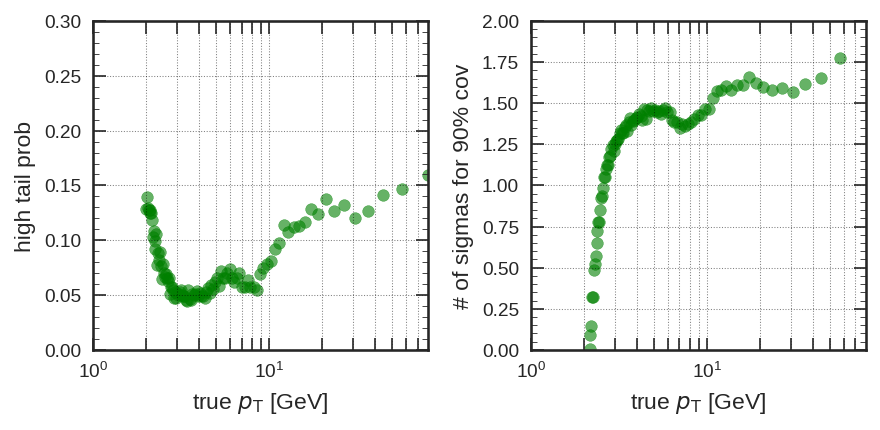

In [25]:
# Misc plots
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

# Estimate high tail that is underestimated by gaus fit
logger.info('high tail prob: {0:.4f}, {1:.4f}, {2:.4f}'.format(zzz[ind_14GeV],zzz[ind_20GeV],zzz[ind_25GeV]))

ax = axs[0]
ax.scatter(xxx, zzz, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.3)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'high tail prob')
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))

# Estimate coverage, find required number of sigmas for 90% coverage
# If truly gaussian, the required number of sigmas is 1.28155
#print(scipy.special.erfinv(0.80) * np.sqrt(2))
logger.info('coverage # of sigmas: {0:.4f}, {1:.4f}, {2:.4f}'.format(ttt[ind_14GeV],ttt[ind_20GeV],ttt[ind_25GeV]))

ax = axs[1]
ax.scatter(xxx, ttt, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,2)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'# of sigmas for 90% cov')
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))

plt.show()